In [1]:
# # pip installs that you might need to download for this program to work
# pip install tensorflow
# pip install tensorflow-addons
# pip install keras


In [2]:
#for this specific dataset, since it was so large it was easier to define a lot of methods to call throughout the code

In [19]:
#importing dependencies
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

#importing pandas and numpy
import pandas as pd
import numpy as np
#setting pandas display preferences
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

#importing time to detemine the ETA 
import time

#importing matplotlib for plotting the accuracy results
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')

# importing sklearn and tensorflow for analyzing and predicting the data
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [20]:
# important note: in order for this code to operate correctly the data path to the metadata must be the exact path as listed
# on your computer, putting the relative path (in terms of where this file is) will not work, the code wont find the data
# this is for when you are working locally
dataPath = pd.read_csv('C://Users//krist//OneDrive//Desktop//plant-categorizing//metaData.csv')

In [21]:
# cloning the data from the repo - for google colab only (if working in google colab comment out the previous box and use this)
# !git clone https://github.com/kconcepcion/plant-categorizing
# dataPath = pd.read_csv('content/plant-cateforizing/metadata')

In [22]:
#creating a function that prints out a desired test highlighted
def printInColor(textMsg, foreTupple = (51, 255, 112), backTupple = (0, 0, 0)):
    rf, gf, bf = foreTupple
    rb, gb, bb = backTupple
    msg = '{0}' + textMsg
    mat = '\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg.format(mat), flush = True)
    print('\33[0m', flush = True)
    return

msg = 'This is a test yo!'
printInColor(msg)

This is a test yo!



In [23]:
# creating a function for later use
# this function plots the value count for each type of plant in the dataframes and compares them side by side
def pltLabelCnt (df, column):
    vcounts = df[column].value_counts()
    labels = vcounts.keys().tolist()
    values = vcounts.tolist()
    plt.figure(figsize = (15,4))
    form = {'family': 'serif', 'color': 'blue', 'size': 25}
    plt.bar(labels, values)
    plt.title('Images per label in training set', fontsize = 24, color = 'blue')
    plt.xticks(rotation = 90, fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.xlabel("Labels", fontdict = form)
    plt.ylabel("Number of Images", fontdict = form)
    plt.show


ONE: X_train len :  7961  y_test len:  996   X_test len:  995   y_train len:  1991
avg image height=  450  avg image weight=  416  aspect ratio (height/width) =  1.0817307692307692


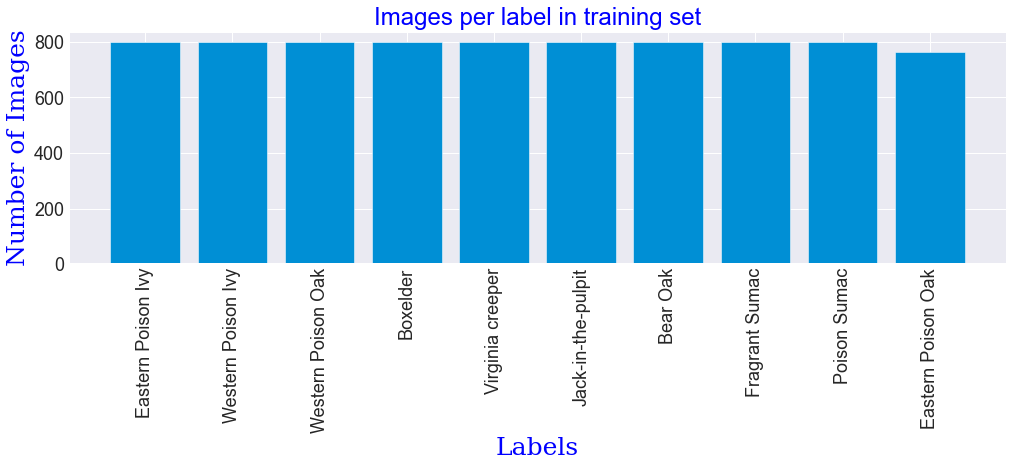

In [24]:
# reading in the data file paths and initialzing the testing dataframes by using train_test_split

def makingDataFrames(dataPath):
    df = pd.read_csv('C://Users//krist//OneDrive//Desktop//plant-categorizing//Resources//Data//metaData.csv')
    df = df.drop(['class_id','scientific_name', 'herbarium22_category_id', 'species_label'], axis =1)
    df.columns = ['slang','path','toxicity']
    X_train, y_train = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 123, stratify = df['slang'])
    X_test, y_test = train_test_split(y_train, train_size = 0.5, shuffle = True, random_state = 123, stratify = y_train['slang'])
    print('ONE: X_train len : ', len(X_train), ' y_test len: ', len(y_test), '  X_test len: ', len(X_test), '  y_train len: ', len(y_train))
    classes = sorted(X_train['slang'].unique())
    cntClass = len(classes)
    pltLabelCnt(X_train, 'slang')
    sampleDf = X_train.sample(n = 100, replace = False)
    height = 0
    width = 0
    cnt = 0
    for i in range(len(sampleDf)):
        filePath = sampleDf['path'].iloc[i]
        try:
            img=cv2.imread(filePath)
            hgt=img.shape[0]
            wdt=img.shape[1]
            #incrementing the counters
            height += hgt
            width += wdt
            cnt += 1
        except:
            pass
    heightAvg = int(height/cnt)
    widthAvg = int(width/cnt)
    aspectRatio = heightAvg / widthAvg
    print('avg image height= ', heightAvg, ' avg image weight= ', widthAvg, ' aspect ratio (height/width) = ', aspectRatio)
    return X_train, y_test, X_test, classes, cntClass

dataPath='C://Users//krist//OneDrive//Desktop//plant-categorizing//Resources//Data//metaData.csv'
X_train, y_test, X_test, classes, cntClass = makingDataFrames(dataPath)


In [25]:
#verifiying all the of dfs are filled
# print(X_train)
# print(" --------------------------------------------------------------------------------------------")
# print(y_train)
# print("-------------------------------------------------------------------------------------------- ")
# print(X_test)
# print("-------------------------------------------------------------------------------------------- ")
# print(y_test)

In [26]:
# this function generates the X_train, y_test, and X_test pictures, we will call it later in the code

def makeGens(batchSize, yCol, X_train, y_test, X_test, imgSize):
    trgen = ImageDataGenerator(horizontal_flip = True)
    TandVgen = ImageDataGenerator()
    msg = '{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='')
    trainGen = trgen.flow_from_dataframe(X_train, x_col='path', y_col=yCol, target_size=imgSize, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batchSize)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='')
    testXGen = TandVgen.flow_from_dataframe(X_test, x_col='path', y_col=yCol, target_size=imgSize, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batchSize)
    length = len(y_test)
    testBatchSize=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    testSteps = int(length/testBatchSize)
    msg = '{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='')
    testGen=TandVgen.flow_from_dataframe(y_test, x_col='path', y_col=yCol, target_size=imgSize,class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=testBatchSize)
    classes=list(testGen.class_indices.keys())
    class_indices=list(trainGen.class_indices.values())
    cntClass = len(classes)
    labels = testGen.labels
    print('test batch size: ', testBatchSize, ' test steps: ', testSteps, ' number of classes: ', cntClass)
    return trainGen, testGen, testXGen, testSteps
    

In [27]:
imgSize = (224,200)
batchSize = 30
yCol = 'slang'
trainGen, testGen, testXGen, testSteps = makeGens(batchSize, yCol, X_train, y_test, X_test, imgSize)

Found 7961 validated image filenames belonging to 10 classes.          for train generator 
Found 995 validated image filenames belonging to 10 classes.           for valid generator 
Found 996 validated image filenames belonging to 10 classes.           for test generator 
test batch size:  12  test steps:  83  number of classes:  10


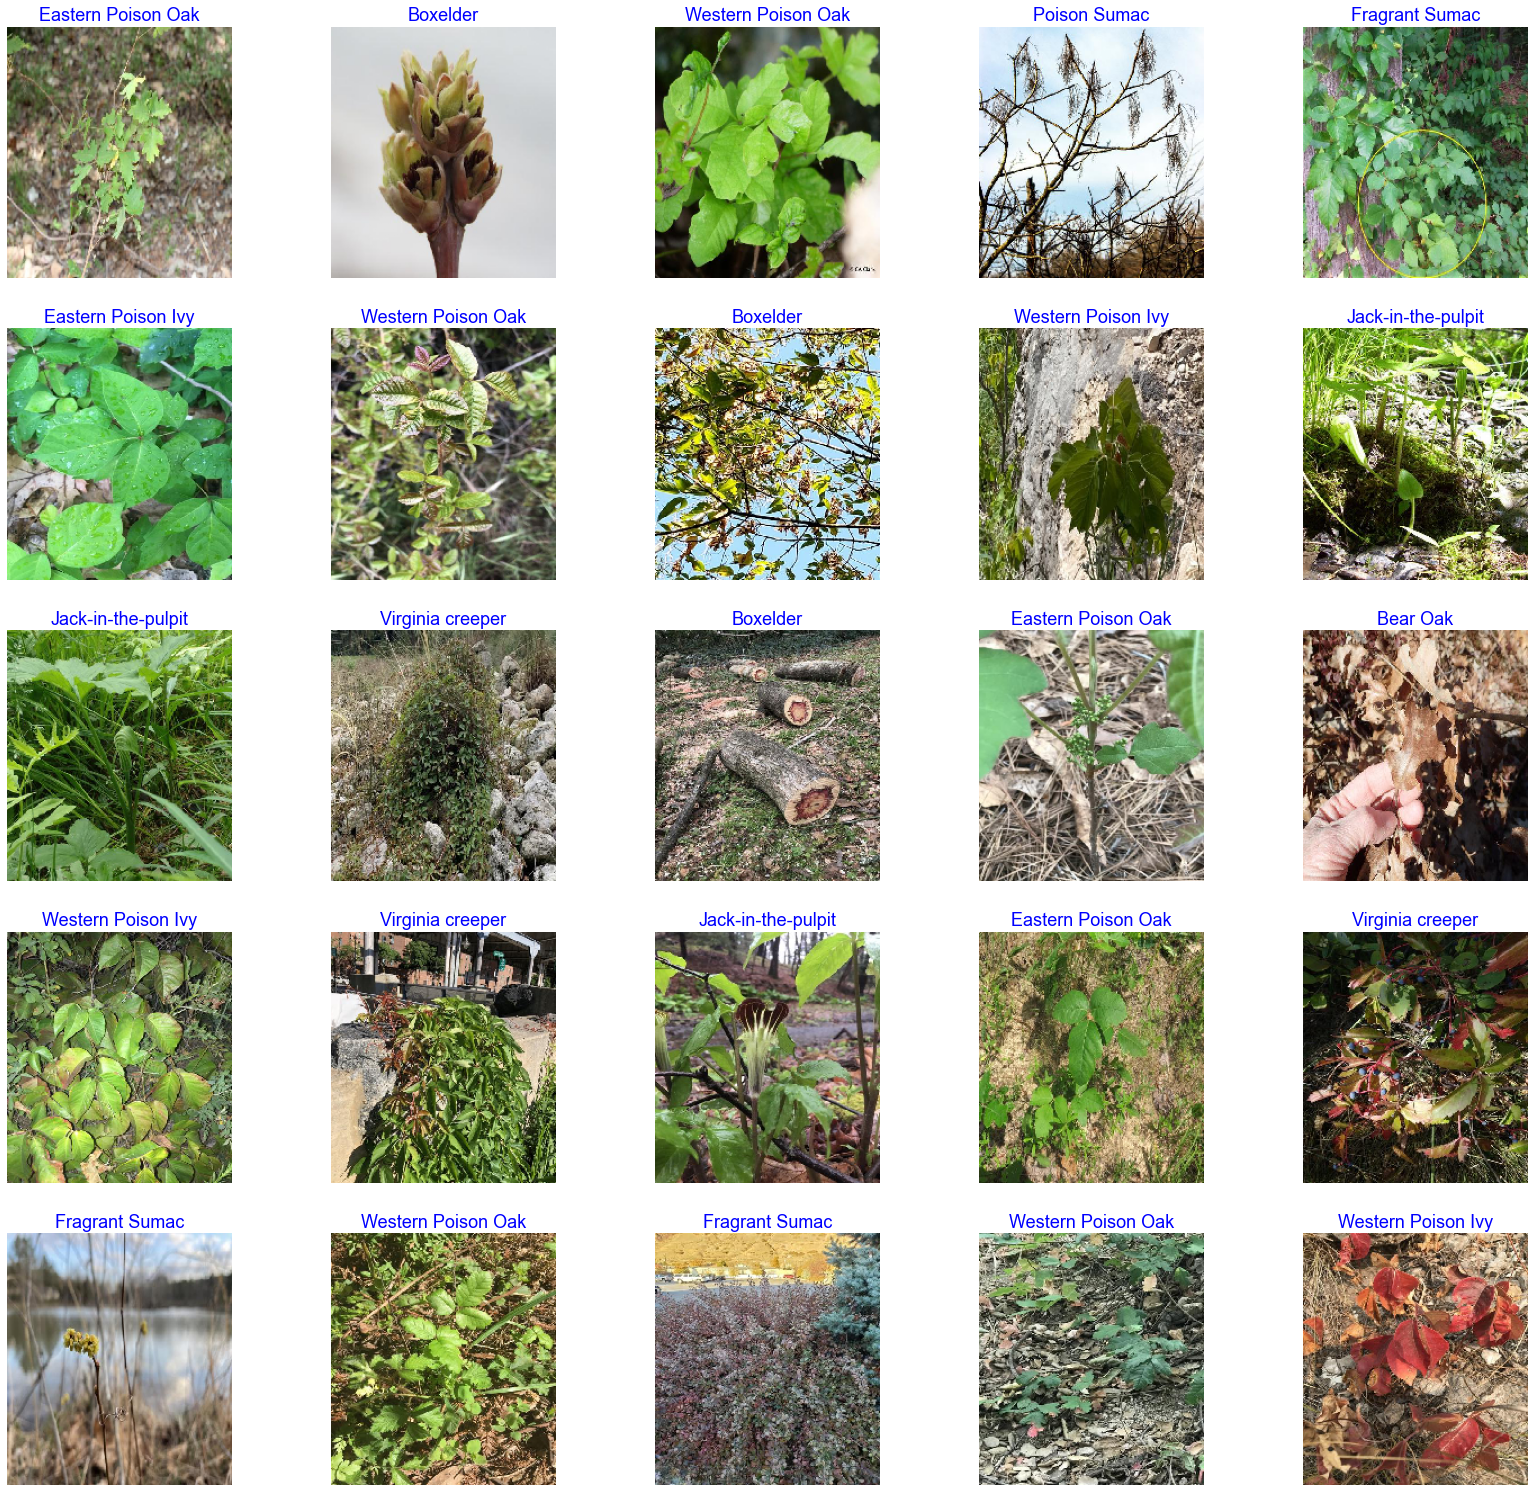

In [28]:
#this function shows samples of the image training
def showImageSamples(gen):
    tDict = gen.class_indices
    classes = list(tDict)
    images, labels = next(gen)
    plt.figure(figsize = (25, 25))
    length = len(labels)
    if length < 25:
        r =length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        className = classes[index]
        plt.title(className, color = 'blue', fontsize = 18)
        plt.axis('off')
    plt.show()
    
#we call this function on the X_train generator
showImageSamples(trainGen)

In [29]:
#this function calculates the f1 score metric, and this just tells you the performance of the classifier program

def f1Score(yTrue, yPredict):
    truePos = K.sum(K.round(K.clip(yTrue * yPredict, 0, 1)))
    possPos = K.sum(K.round(K.clip(yTrue, 0, 1)))
    predPos = K.sum(K.round(K.clip(yPredict, 0, 1)))
    precision = truePos / (predPos + K.epsilon())
    recall = truePos / (possPos + K.epsilon())
    f1Val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1Val

In [30]:
# creaitng the training model method, this method will be called each time for each enoch, and with each call
# the accuracy score will get better and better. this is why we chose transfer learning over cnn

def makeModel(imgSize, lr, modNum = 3):
    imgShape = (imgSize[0], imgSize[1], 3)
    if modNum == 0:
        baseModel = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=imgShape, pooling='max') 
        msg='Created EfficientNet B0 model'
    elif modNum == 3:
        baseModel = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=imgShape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif modNum == 5:
        baeModel = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=imgShape, pooling='max') 
        msg='Created EfficientNet B5 model'
    else:
        baseModel = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=imgShape, pooling='max') 
        msg='Created EfficientNet B7 model'
        
    baseModel.trainable=True
    x = baseModel.output
    x = BatchNormalization(axis=-1, momentum = 0.99, epsilon = 0.001)(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x = Dropout(rate = 0.4, seed = 123)(x)
    output = Dense(cntClass, activation = 'softmax')(x)
    model = Model(inputs = baseModel.input, outputs = output)
    model.compile(Adamax(learning_rate = lr), loss = 'categorical_crossentropy', metrics=['accuracy', f1Score, 'AUC'])
    msg = msg + f' with initial learning rate set to {lr}'
    printInColor(msg)
    return model

lr = .001
model = makeModel(imgSize, lr)

Created EfficientNet B3 model with initial learning rate set to 0.001



In [31]:
# creating the keras callback allows for the user to either continue training the set or halt traning
class LRask(keras.callbacks.Callback):
    def __init__ (self, model, epochs, askEpoch, dwell = True, factor = 0.4):
        super(LRask, self).__init__()
        self.model = model
        self.askEpoch = askEpoch
        self.epochs = epochs
        self.ask = True 
        self.lowestVloss = np.inf
        self.lowestAloss = np.inf
        self.best_weights=self.model.get_weights()
        self.bestEpoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def getList(self):
        return self.plist, self.alist
    
    def onTrainBegin(self, logs = None):
        if self.askEpoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.askEpoch=1
        if self.askEpoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('askEpoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False
        if self.epochs == 1:
            self.ask=False
        else:
            msg = f'training will proceed until epoch {askEpoch} then you will be asked to' 
            printInColor(msg)
            msg = 'enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            printInColor(msg)
            if self.dwell:
                msg = 'learning rate will automatically adjust during training'
                printInColor(msg, (0, 255, 0))
        self.startTime = time.time()
        
    def onTrainEnd(self, logs = None):
        msg = f'loading model with weights from epoch {self.bestEpoch}'
        print_in_color(msg, (0,255,255))
        self.model.setWeights(self.best_weights)
        trDuration = time.time() - self.startTime
        hours = trDuration
        mintues = (trDuration - (hours * 3600))
        seconds = trDuration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        printInColor(msg)
        
    def onEpochEnd(self, epoch, logs = None):
        vLoss = logs.get('valLoss')
        aLoss = logs.get('loss')
        
        if epoch > 0:
            vLossDiff = self.lowestVloss - vLoss
            pimprov = (vLossDiff / self.lowestVloss) * 100
            self.plist.append(pimprov)
            aLossDiff = self.lowestAloss - aLoss
            aimprov = (aLossDiff/self.lowestALoss) * 100
            self.alist.append(aimprov)
        else:
            pimprov = 0.0
            aimprov = 0.0
        if vLoss < self.lowestVloss:
            self.lowestVloss = vLoss
            self.best_weights = self.model.get_weights()
            self.bestEpoch = epoch + 1
            msg=f'\n validation loss of {vLoss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            printInColor(msg, (0,255,0))
        else:
            pimprov = abs(pimprov)
            msg=f'\n validation loss of {vLoss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowestVloss:7.4f} keeping weights from epoch {str(self.bestEpoch)} as best weights'
            printInColor(msg, (255,255,0))
            if self.dwell:
                lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                newLr = lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {newLr:8.6f}, model weights set to best weights'
                printInColor(msg)
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.setWeights(self.best_weights)
        
        if aLoss < self.lowestAloss:
            self.lowestAloss = aLoss
        if self.ask:
            if epoch + 1 == self.askEpoch:
                msg='press enter to continue or enter a comment  below '
                printInColor(msg)
                comment=input(' ')
                
                if comment != '':
                    comment = 'User comment: ' + comment
                    printInColor(comment, (155, 245, 66))
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                printInColor(msg)
                ans=input()
            
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    printInColor(msg)
                    self.model.stop_training = True
                else:
                    self.askEpoch += int(ans)
                    if self.askEpoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.askEpoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        printInColor(msg)
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr))
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            printInColor(msg)
                            ans=input(' ')
                            if ans == '':
                                msg=f'keeping current LR of {lr:7.5f}'
                                printInColor(msg)
                            else:
                                newLr = float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, newLr) 
                                msg=f' changing LR to {ans}'
                                printInColor(msg)
                        
                        
            
            

In [32]:
# the number of epochs ran determines how long the code will run (keep in mind each one takes 30 min)
# to get an accuracy score higher than 75% it takes around 4-5 iterations
epochs = 10
# epochs = 40
askEpoch = 10
ask = LRask(model, epochs, askEpoch)
callbacks = [ask]

In [33]:
# ---note: each iteration takes around 30min, and the ETA calculator updates every 6-7 seconds
#    start at your own risk!!!!  
#        {}           {}
#          \  _---_  /
#           \/     \/
#            |() ()|
#             \ + /
#            / HHH  \
#           /  \_/   \
#         {}          {}
history=model.fit(x = trainGen , epochs = epochs, verbose = 1, callbacks = callbacks,  validation_data = testXGen, validation_steps = None, shuffle = False, initial_epoch = 0)

Epoch 1/10
266/266 [==============================] - 1574s 6s/step - loss: 8.0444 - accuracy: 0.4060 - f1Score: 0.3548 - auc: 0.8048 - val_loss: 6.1945 - val_accuracy: 0.5759 - val_f1Score: 0.5465 - val_auc: 0.9079
Epoch 2/10
266/266 [==============================] - 1572s 6s/step - loss: 4.9183 - accuracy: 0.6443 - f1Score: 0.6016 - auc: 0.9346 - val_loss: 4.0538 - val_accuracy: 0.6392 - val_f1Score: 0.6038 - val_auc: 0.9373
Epoch 3/10
266/266 [==============================] - 1567s 6s/step - loss: 3.1612 - accuracy: 0.7458 - f1Score: 0.7120 - auc: 0.9661 - val_loss: 2.7947 - val_accuracy: 0.6844 - val_f1Score: 0.6464 - val_auc: 0.9438
Epoch 4/10
266/266 [==============================] - 1577s 6s/step - loss: 2.0660 - accuracy: 0.8121 - f1Score: 0.7907 - auc: 0.9810 - val_loss: 2.0569 - val_accuracy: 0.7015 - val_f1Score: 0.6871 - val_auc: 0.9494
Epoch 5/10
266/266 [==============================] - 1569s 6s/step - loss: 1.3749 - accuracy: 0.8728 - f1Score: 0.8571 - auc: 0.9897 - 

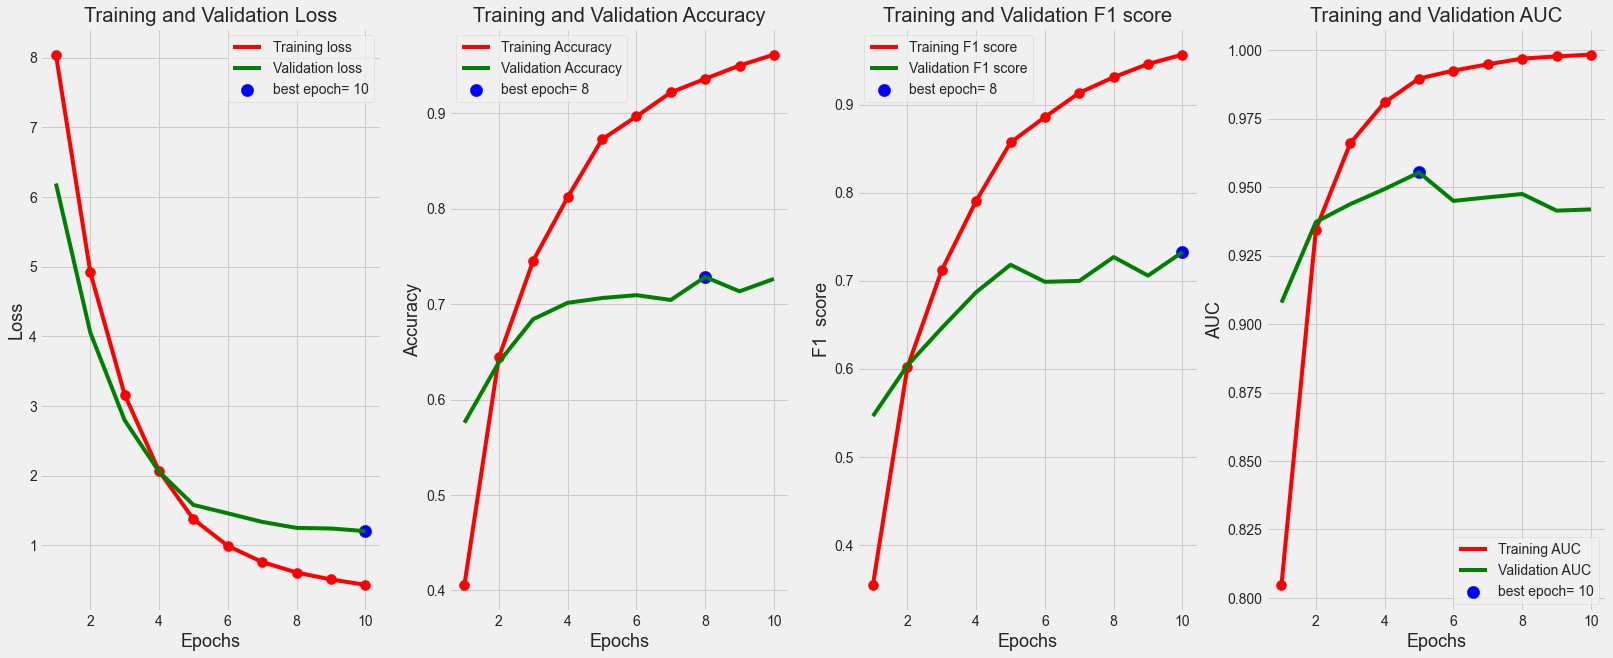

In [34]:
#by going in and using the .hsitory function we can pull the previously printed numbers and chart them using matplotlib
#then we call the plot function on the history variable that we made previously
def trPlot(trData):
    start_epoch = 0
    tacc = trData.history['accuracy']
    tloss = trData.history['loss']
    vacc = trData.history['val_accuracy']
    vloss = trData.history['val_loss']
    tf1 = trData.history['f1Score']
    vf1 = trData.history['val_f1Score']
    tauc = trData.history['auc']
    vauc = trData.history['val_auc']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    auc_index=np.argmax(vauc)
    val_highest_auc=vauc[auc_index]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    auc_label='best epoch= ' + str(auc_index + 1 + start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=4, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()
    axes[3].plot(Epochs,tauc, 'r', label='Training AUC')
    axes[3].plot(Epochs,vauc,'g',label='Validation AUC' )
    axes[3].scatter(auc_index+1 +start_epoch,val_highest_auc, s=150, c= 'blue', label=sc_label)
    axes[3].scatter(Epochs, tauc, s=100, c='red')    
    axes[3].set_title('Training and Validation AUC')
    axes[3].set_xlabel('Epochs', fontsize=18)
    axes[3].set_ylabel('AUC', fontsize=18)
    axes[3].legend()
    plt.tight_layout    
    plt.show()
    return 
    
trPlot(history)
    
    
    
    
    